In [1]:
import pandas as pd

df = pd.read_pickle("df_reduced.pkl")
df.head()

,name,date,quantity,exposure,tracked_id,centered_traj,cluster_agg
0,balder,01062021-25,0,0.0,1.0,"[[-11.354838709677423, 2.516129032258064], [-1...",21
1,balder,01062021-25,0,0.0,3.0,"[[-32.243697478991606, -0.6134453781512619], [...",12
2,balder,01062021-25,0,0.0,4.0,"[[3.5581395348837077, 9.0], [3.558139534883707...",21
3,balder,01062021-25,0,0.0,6.0,"[[23.952941176470574, 1.7176470588235304], [22...",45
4,balder,01062021-25,0,0.0,7.0,"[[2.2413793103448256, -1.6896551724137936], [1...",11


In [2]:
import numpy as np
import pandas as pd
from numpy.fft import fft
from sklearn.cluster import KMeans
import ast

def fourier_descriptors(trajectory):
    # Assuming the trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Apply Fourier Transform
    fd_x = fft(x)
    fd_y = fft(y)

    # Combine the descriptors and return
    return np.concatenate([np.abs(fd_x), np.abs(fd_y)])

In [3]:
from scipy.interpolate import interp1d

def interpolate_trajectory(trajectory, num_points=50):
    # Assuming trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Create an interpolation function
    length = len(trajectory)
    f_x = interp1d(np.linspace(0, 1, length), x, kind='linear')
    f_y = interp1d(np.linspace(0, 1, length), y, kind='linear')

    # Interpolate to a common number of points
    new_x = f_x(np.linspace(0, 1, num_points))
    new_y = f_y(np.linspace(0, 1, num_points))

    return np.column_stack((new_x, new_y))


In [4]:
df['interpolated_traj'] = df['centered_traj'].apply(interpolate_trajectory)
df['fourier_descriptors'] = df['interpolated_traj'].apply(fourier_descriptors)

In [5]:
n_clusters = [n for n in range(2,10)]
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
# Extracting the Fourier Descriptors as features for clustering
features = np.stack(df['fourier_descriptors'].values)

for n in n_clusters:    # You may need to adjust the number of clusters 'n_clusters'
    kmeans = KMeans(n)
    df['KMean_cluster_'+str(n)] = kmeans.fit_predict(features)

/home/rodriguez/miniconda3/envs/traj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rodriguez/miniconda3/envs/traj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rodriguez/miniconda3/envs/traj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rodriguez/miniconda3/envs/traj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarni

In [7]:
df.sample(3)

,name,date,quantity,exposure,tracked_id,centered_traj,cluster_agg,interpolated_traj,fourier_descriptors,KMean_cluster_2,KMean_cluster_3,KMean_cluster_4,KMean_cluster_5,KMean_cluster_6,KMean_cluster_7,KMean_cluster_8,KMean_cluster_9
9354,emperador,26082021-101,10n,0.0,25.0,"[[-11.504201680672281, 12.495798319327719], [-...",67,"[[-11.504201680672281, 12.495798319327719], [-...","[0.3205282112838894, 190.9814150286617, 94.155...",0,2,2,1,3,1,0,3
3014,balder,01062021-63,100n,30.0,133.0,"[[14.142857142857139, 9.666666666666657], [13....",79,"[[14.142857142857139, 9.666666666666657], [13....","[0.6734693877552074, 217.15324890372924, 99.43...",0,2,0,4,3,1,0,3
2539,balder,01062021-57,1u,30.0,17.0,"[[-16.092436974789962, -12.621848739495803], [...",100,"[[-16.092436974789962, -12.621848739495803], [...","[0.17406962784872348, 357.8449542983681, 152.5...",0,0,0,4,3,3,5,1


In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming 'features' is a 2D NumPy array containing your Fourier Descriptors
# and 'cluster_labels' is the array of cluster labels from KMeans

for n in n_clusters:
    cluster_labels = df['KMean_cluster_'+str(n)]
    # Compute the silhouette scores for each sample
    silhouette_vals = silhouette_samples(features, cluster_labels)

    # Calculate the mean silhouette score
    mean_silhouette = silhouette_score(features, cluster_labels)

    # You can also compute the mean silhouette score for each cluster
    cluster_silhouette_vals = []
    for i in range(n):
        cluster_silhouette_vals.append(silhouette_vals[cluster_labels == i].mean())
    print(f'n_clusters = {n}')
    print("Mean silhouette score for all samples:", mean_silhouette)
    print("Mean silhouette score for each cluster:", cluster_silhouette_vals)

n_clusters = 2
Mean silhouette score for all samples: 0.4080773199339827
Mean silhouette score for each cluster: [0.5304000347462827, 0.1369362002271266]
n_clusters = 3
Mean silhouette score for all samples: 0.4028089724471427
Mean silhouette score for each cluster: [0.24255113750289087, 0.2358100692155042, 0.507146414195355]
n_clusters = 4
Mean silhouette score for all samples: 0.32059977567849984
Mean silhouette score for each cluster: [0.2521585881189677, 0.23270504348204185, 0.42061439551714996, 0.1895560760165149]
n_clusters = 5
Mean silhouette score for all samples: 0.3172923823715105
Mean silhouette score for each cluster: [0.1802583341189107, 0.4432321710421382, 0.23046390545074041, 0.20578001704329402, 0.279661317623572]
n_clusters = 6
Mean silhouette score for all samples: 0.3100836144779234
Mean silhouette score for each cluster: [0.41873214258651187, 0.17424920246578995, 0.20569919675930076, 0.28588062727041436, 0.28377178209576354, 0.22221061573090148]
n_clusters = 7
Mean 

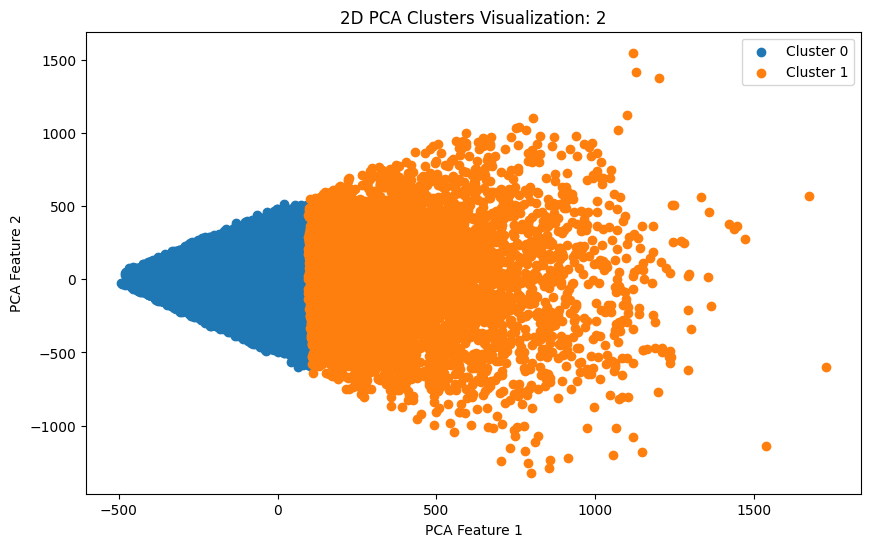

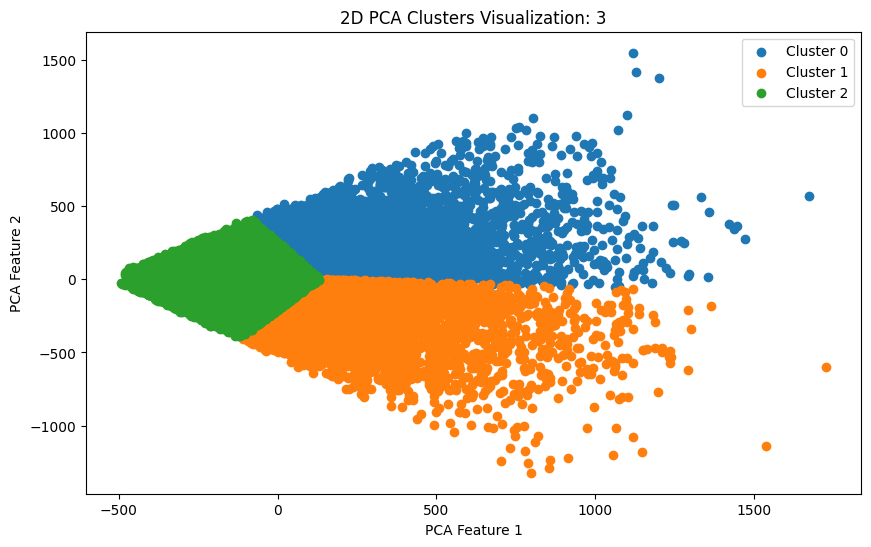

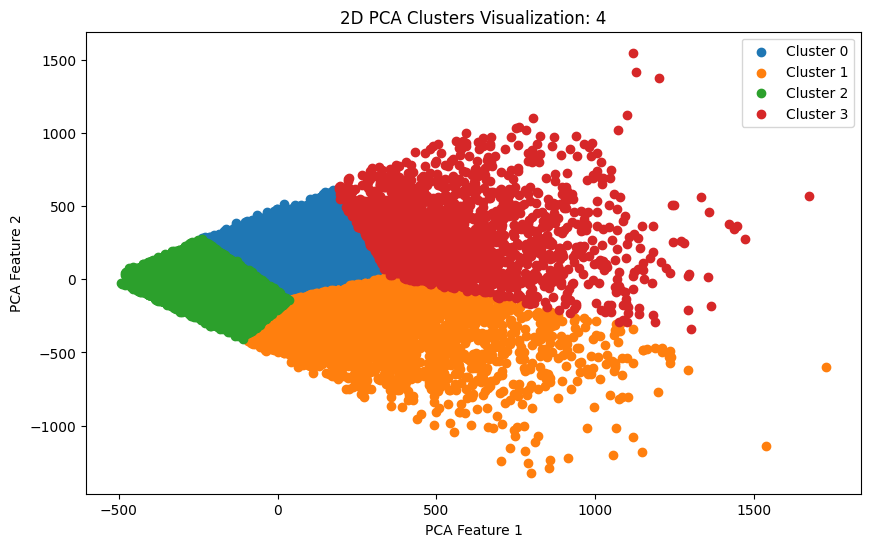

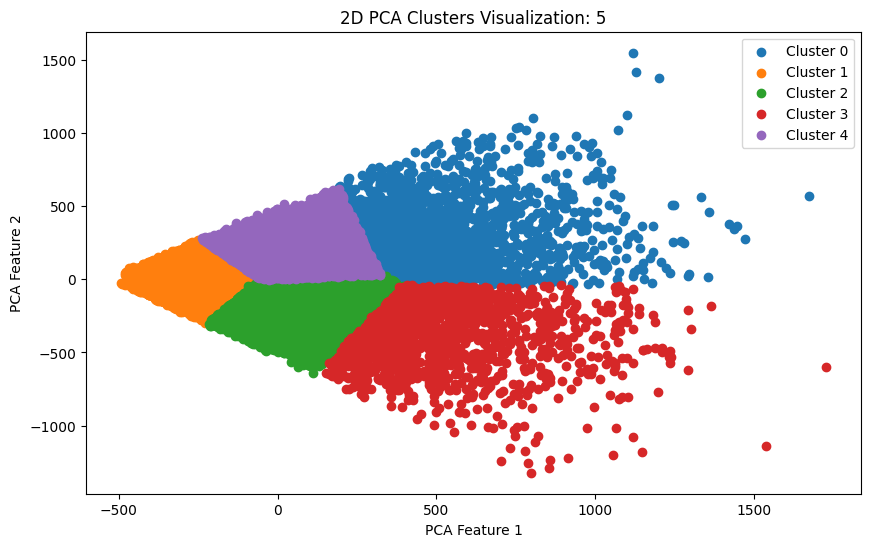

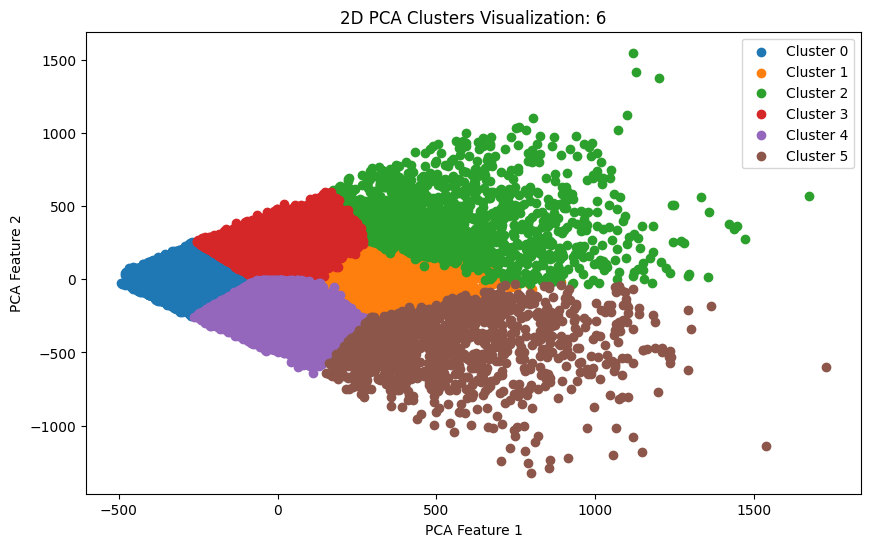

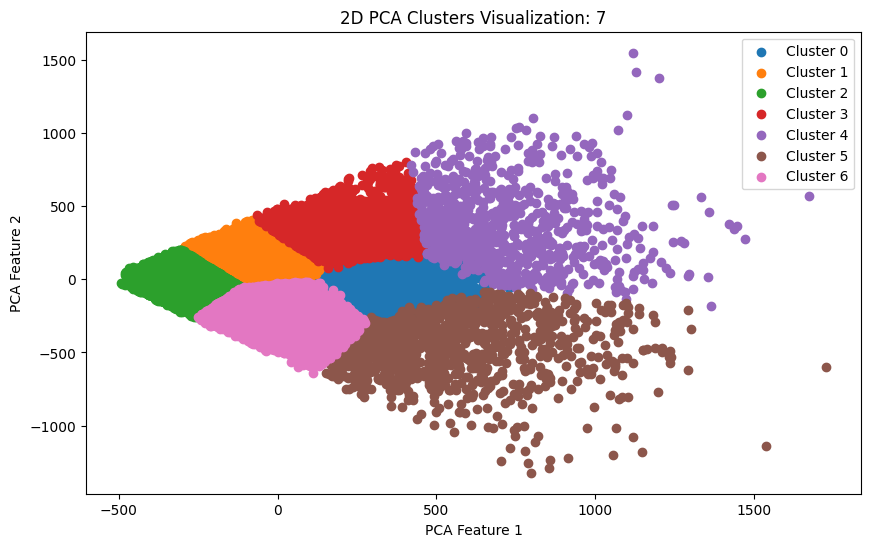

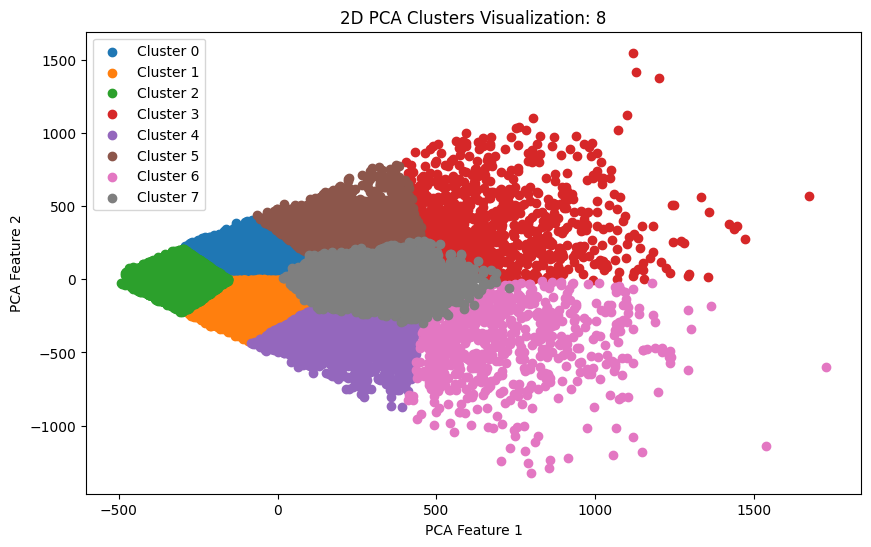

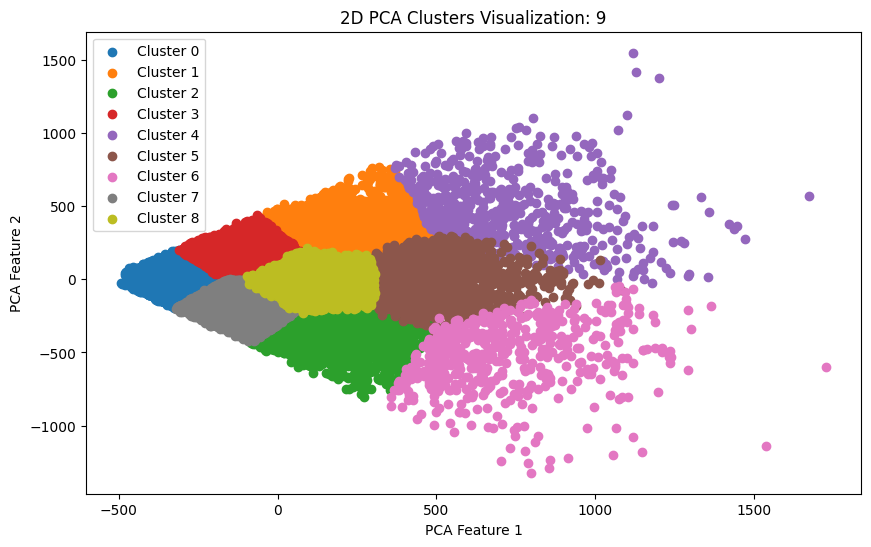

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'features' is a 2D NumPy array containing your Fourier Descriptors
# and 'cluster_labels' is the array of cluster labels from KMeans

    # Reduce the feature space to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

for n in n_clusters:
    cluster_labels = df['KMean_cluster_'+str(n)]

    # Plot the reduced data points with colors corresponding to their cluster label
    plt.figure(figsize=(10, 6))
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        # Filter data points that belong to the current label
        label_features = reduced_features[cluster_labels == label]
        plt.scatter(label_features[:, 0], label_features[:, 1], label=f'Cluster {label}')

    plt.title('2D PCA Clusters Visualization: '+str(n))
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.legend()
    plt.show()


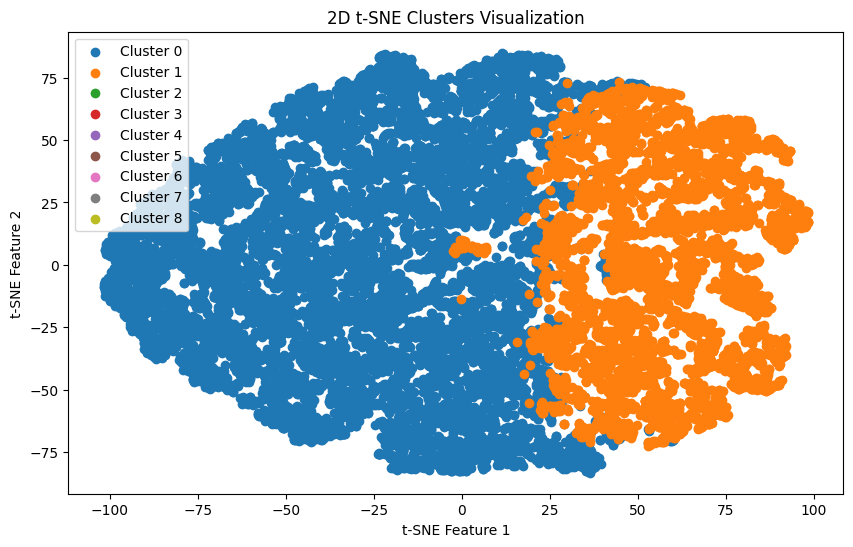

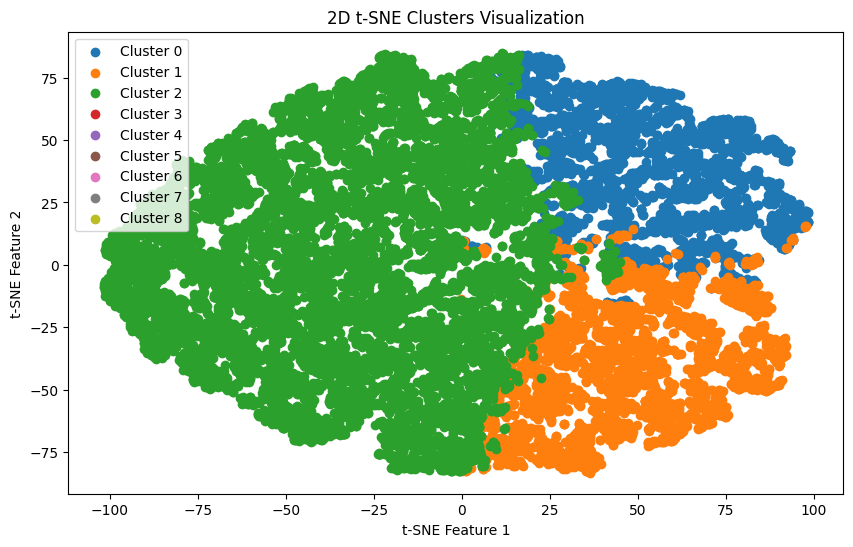

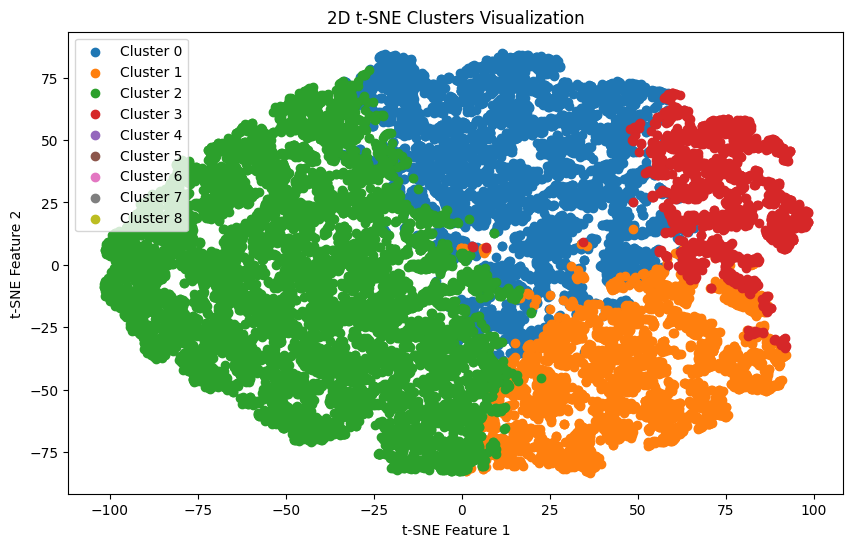

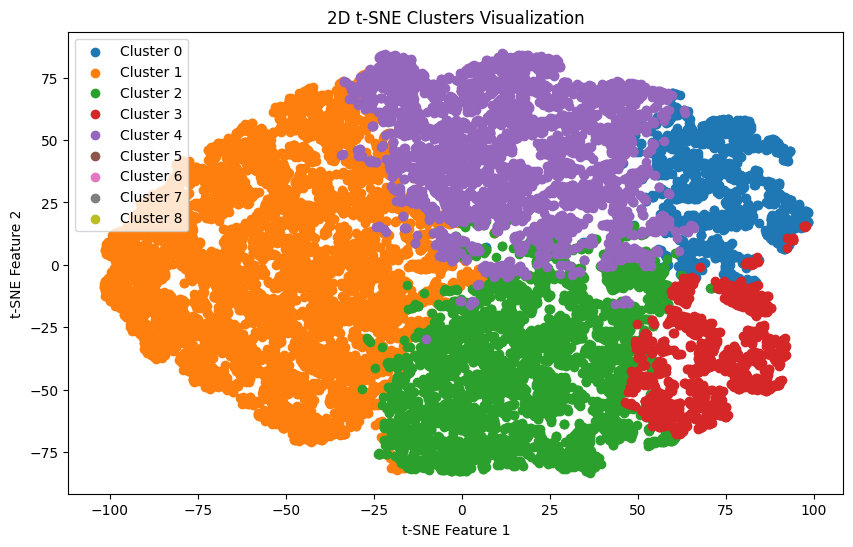

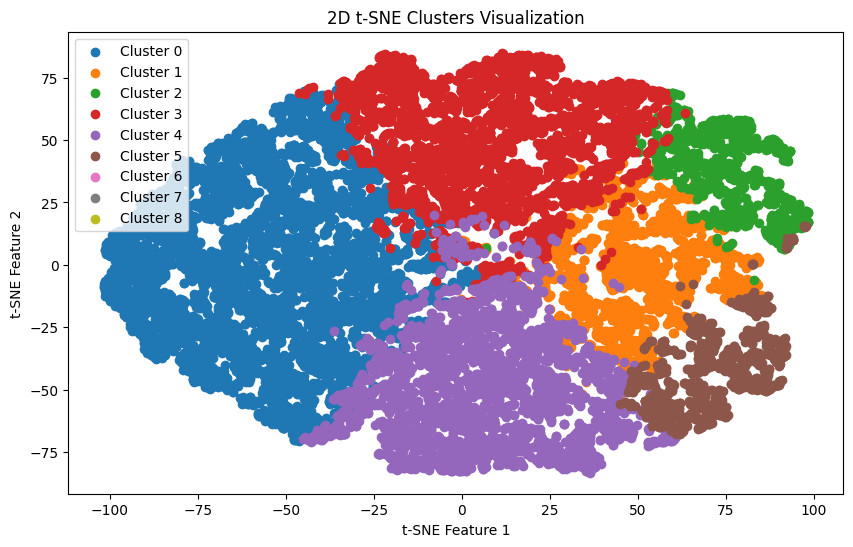

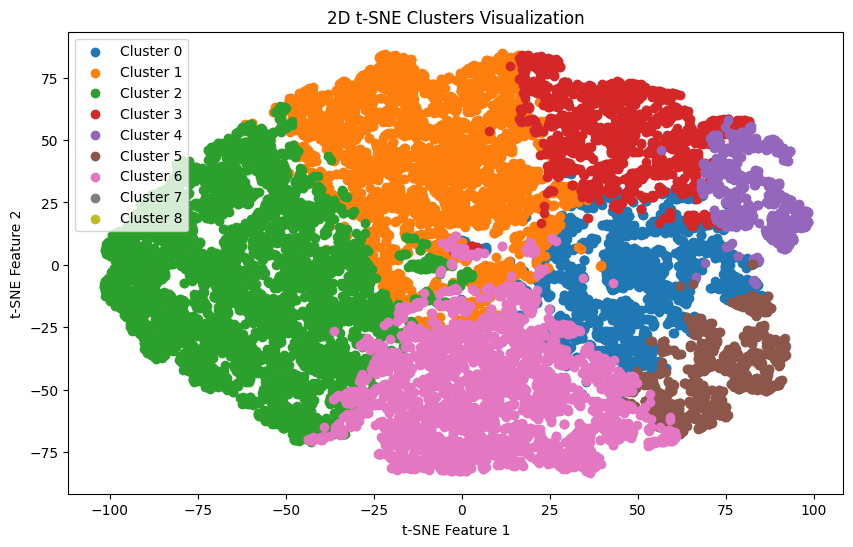

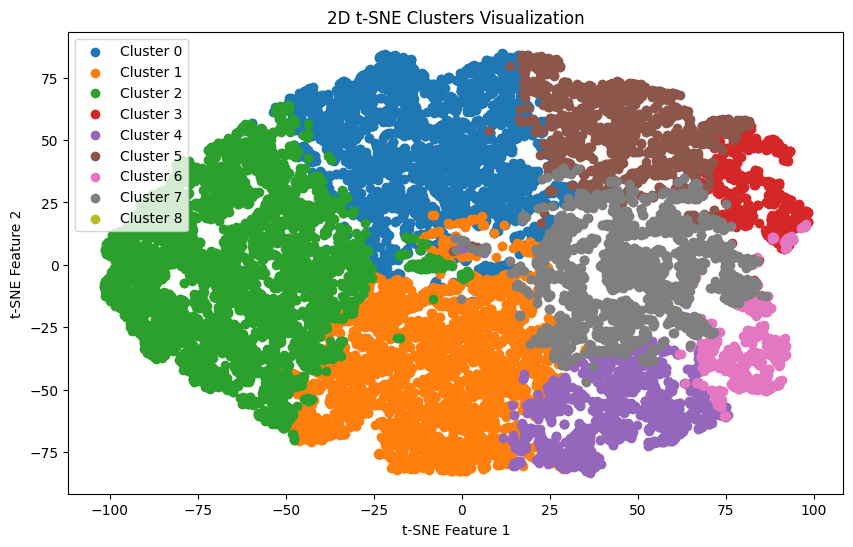

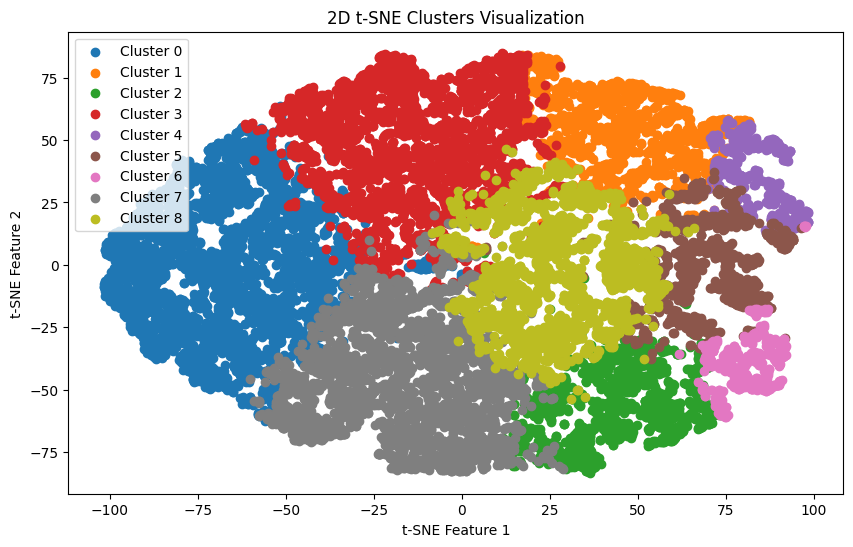

In [11]:
from sklearn.manifold import TSNE

# Use t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_features_tsne = tsne.fit_transform(features)

for n in n_clusters:
    cluster_labels = df['KMean_cluster_'+str(n)]
    # Plot the reduced data points with colors corresponding to their cluster label
    plt.figure(figsize=(10, 6))
    for label in unique_labels:
        # Filter data points that belong to the current label
        label_features = reduced_features_tsne[cluster_labels == label]
        plt.scatter(label_features[:, 0], label_features[:, 1], label=f'Cluster {label}')

    plt.title('2D t-SNE Clusters Visualization')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.legend()
    plt.show()


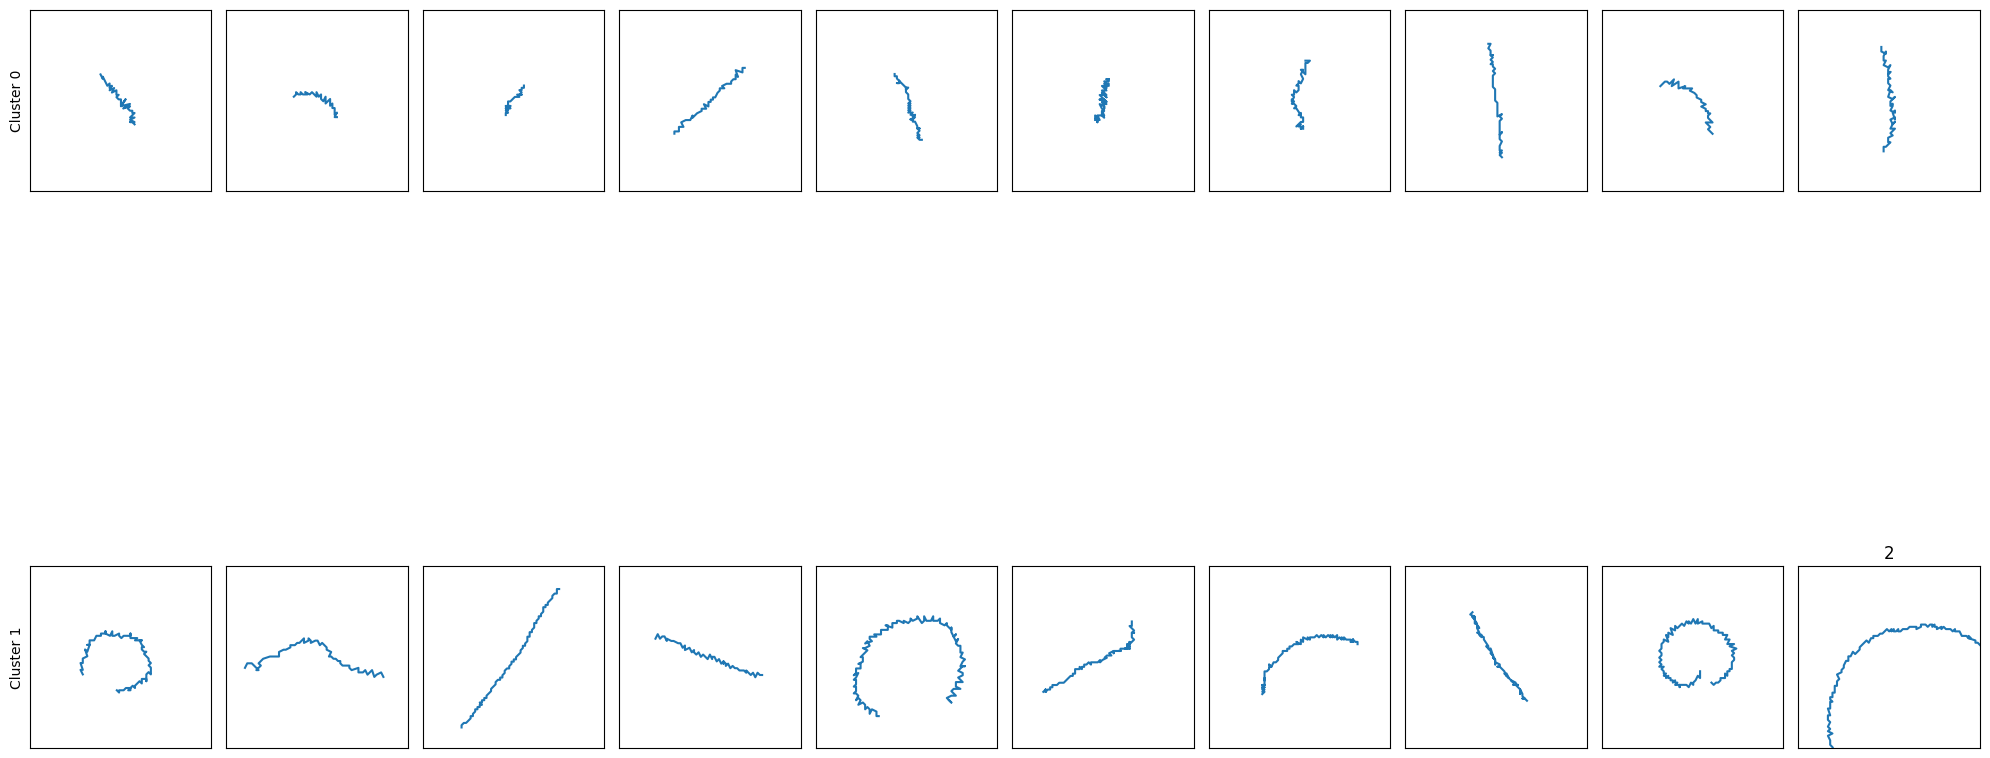

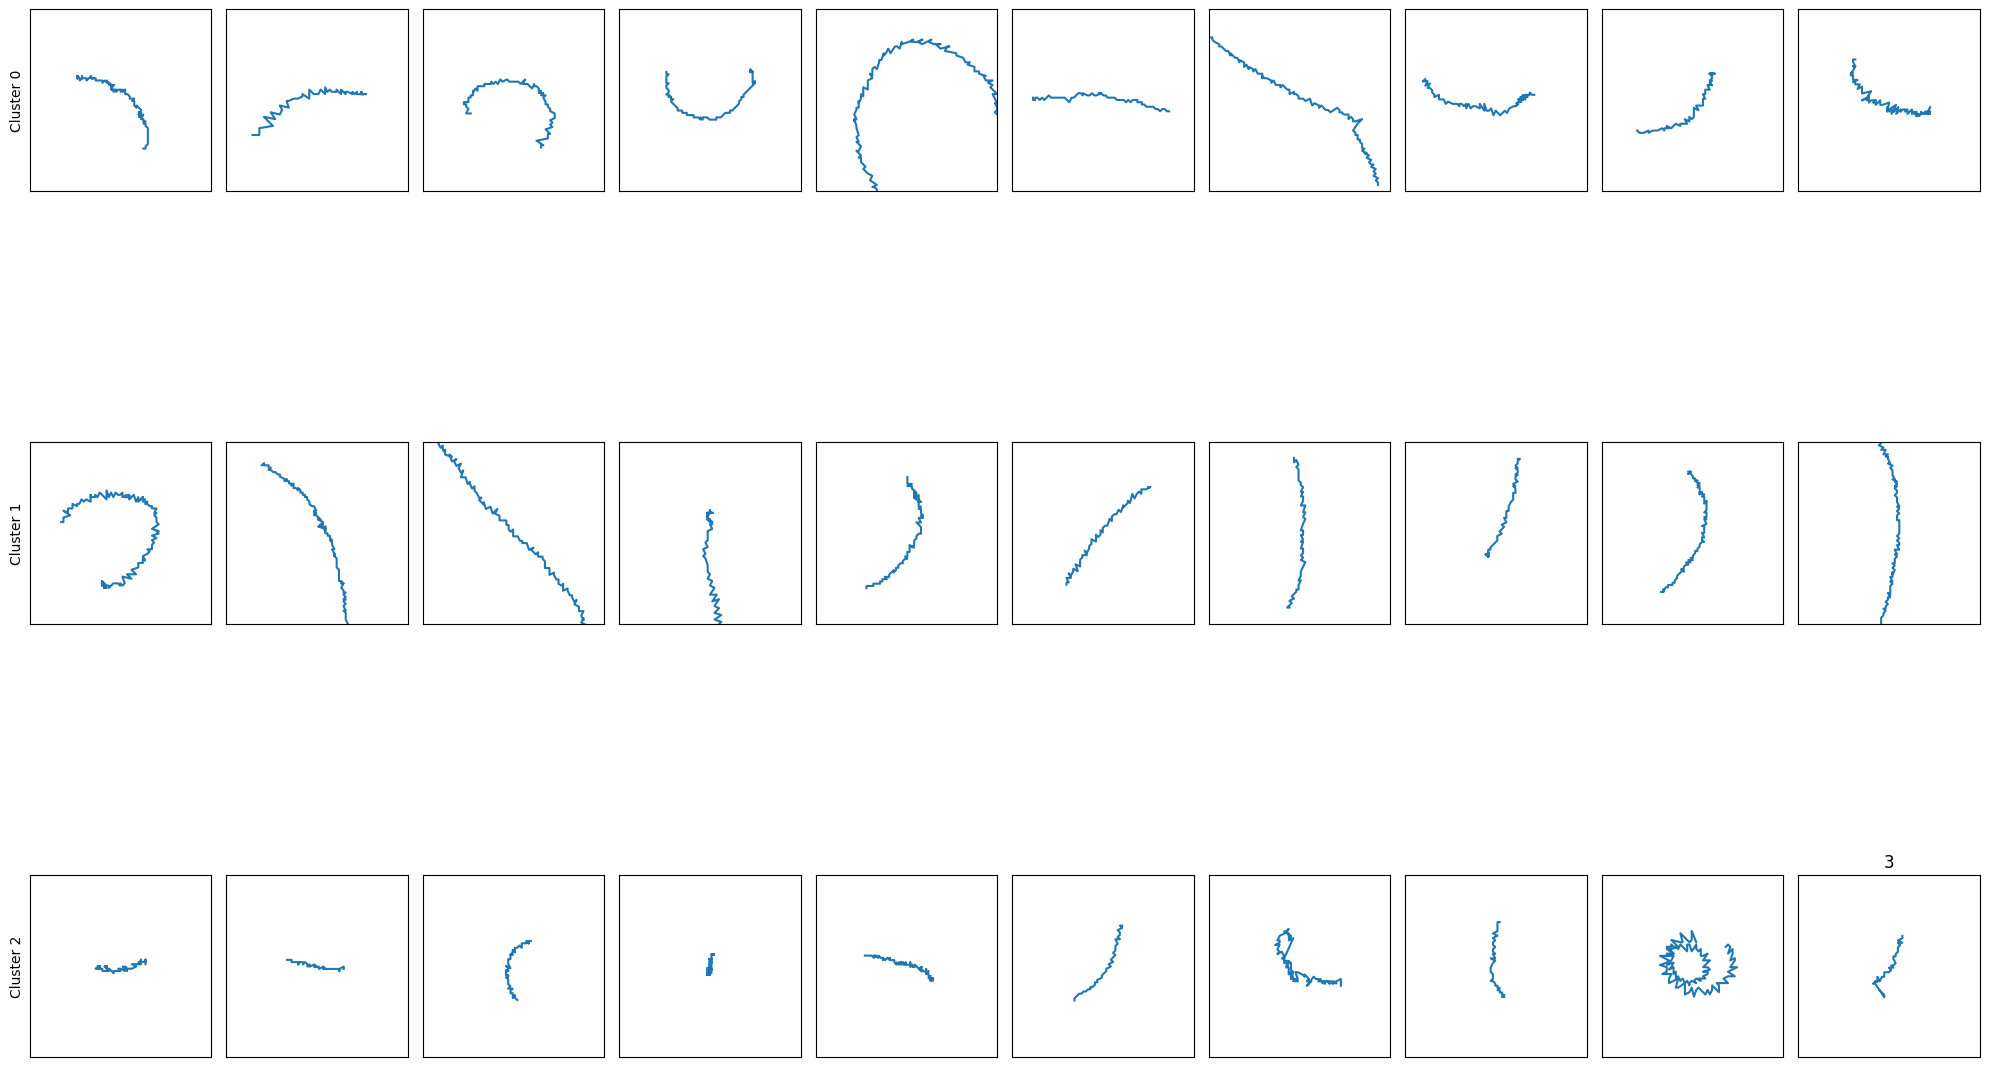

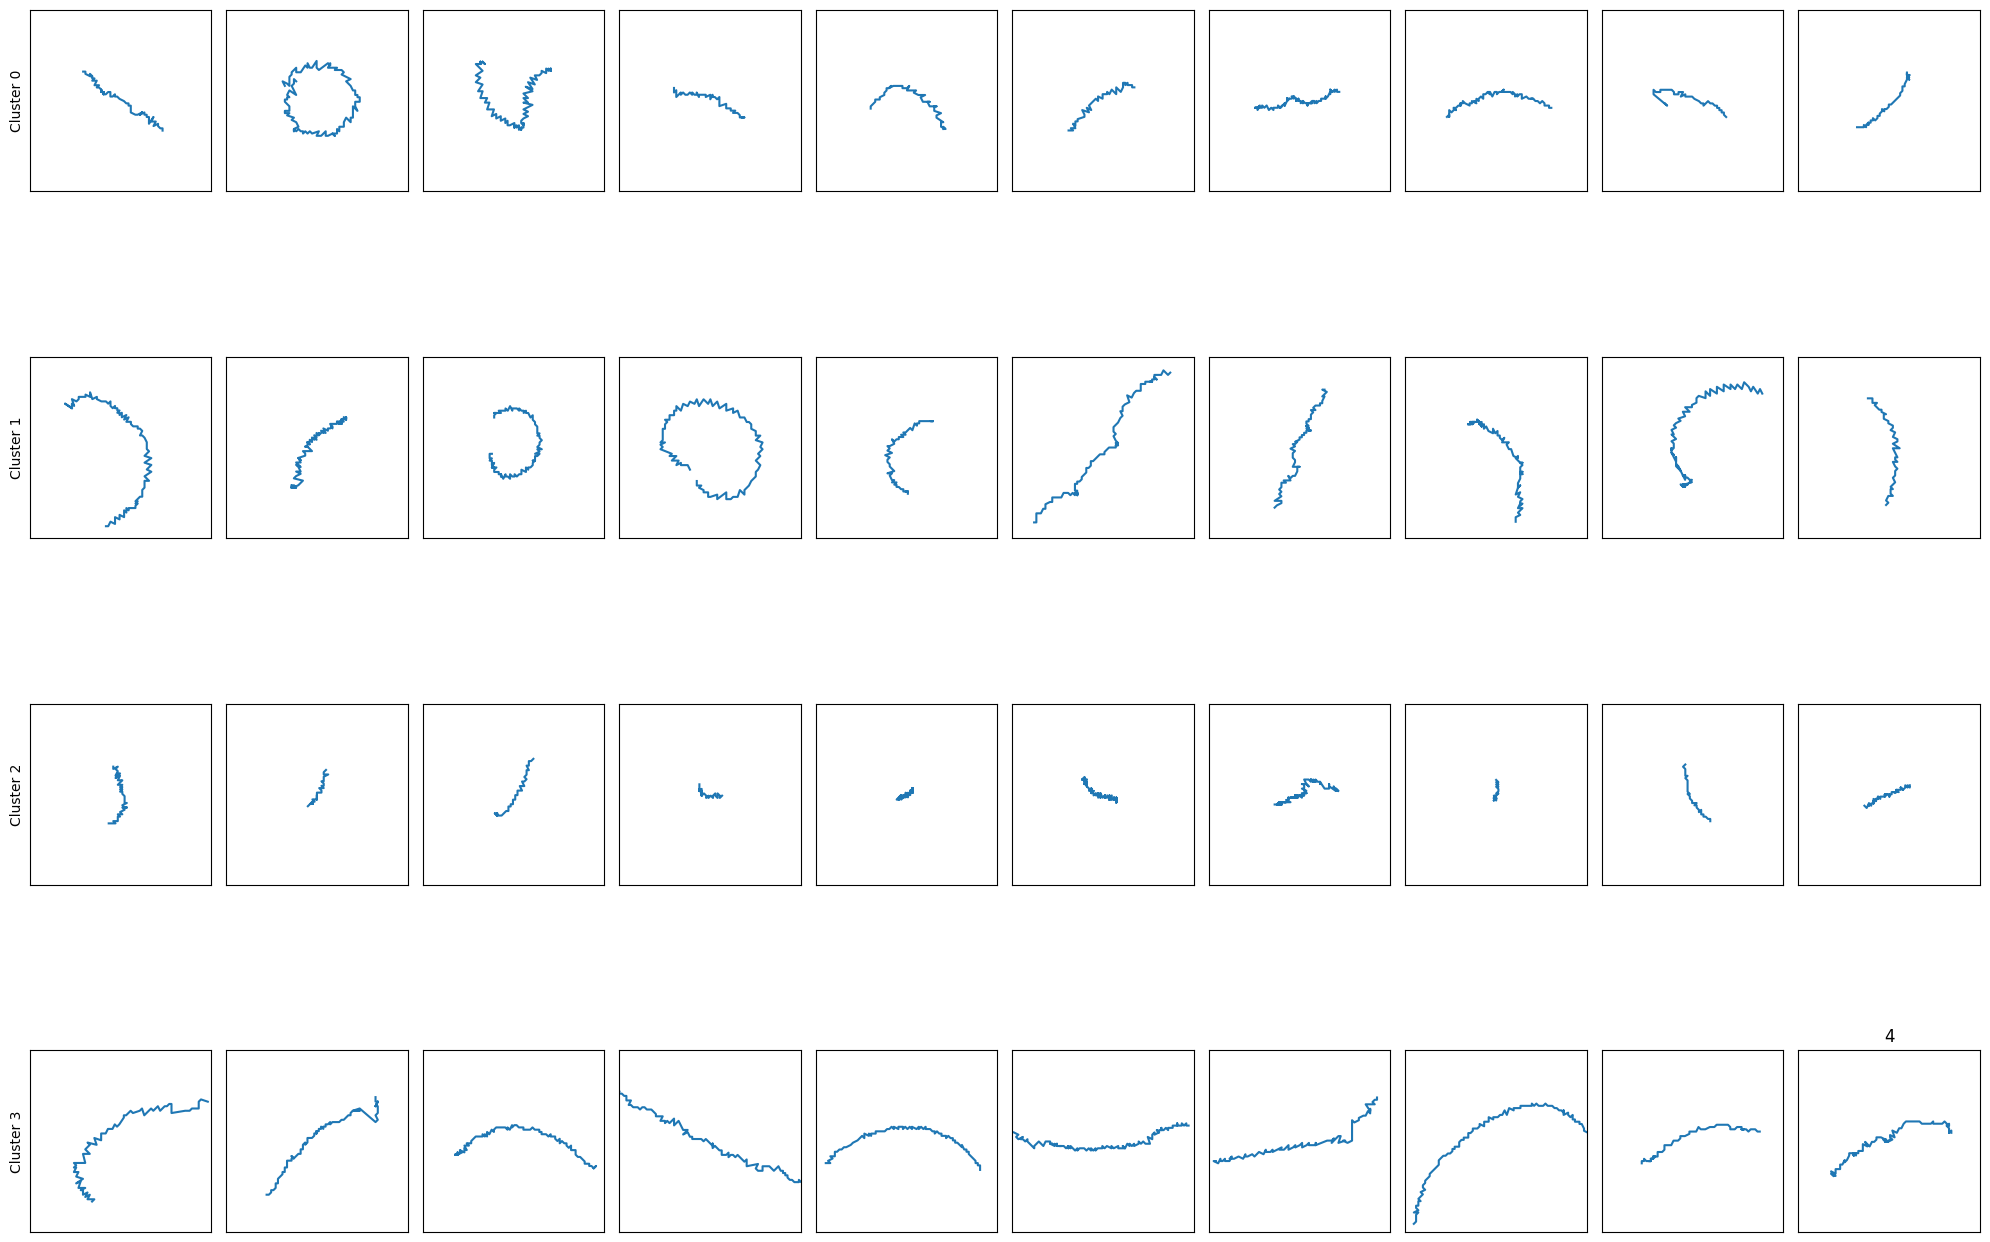

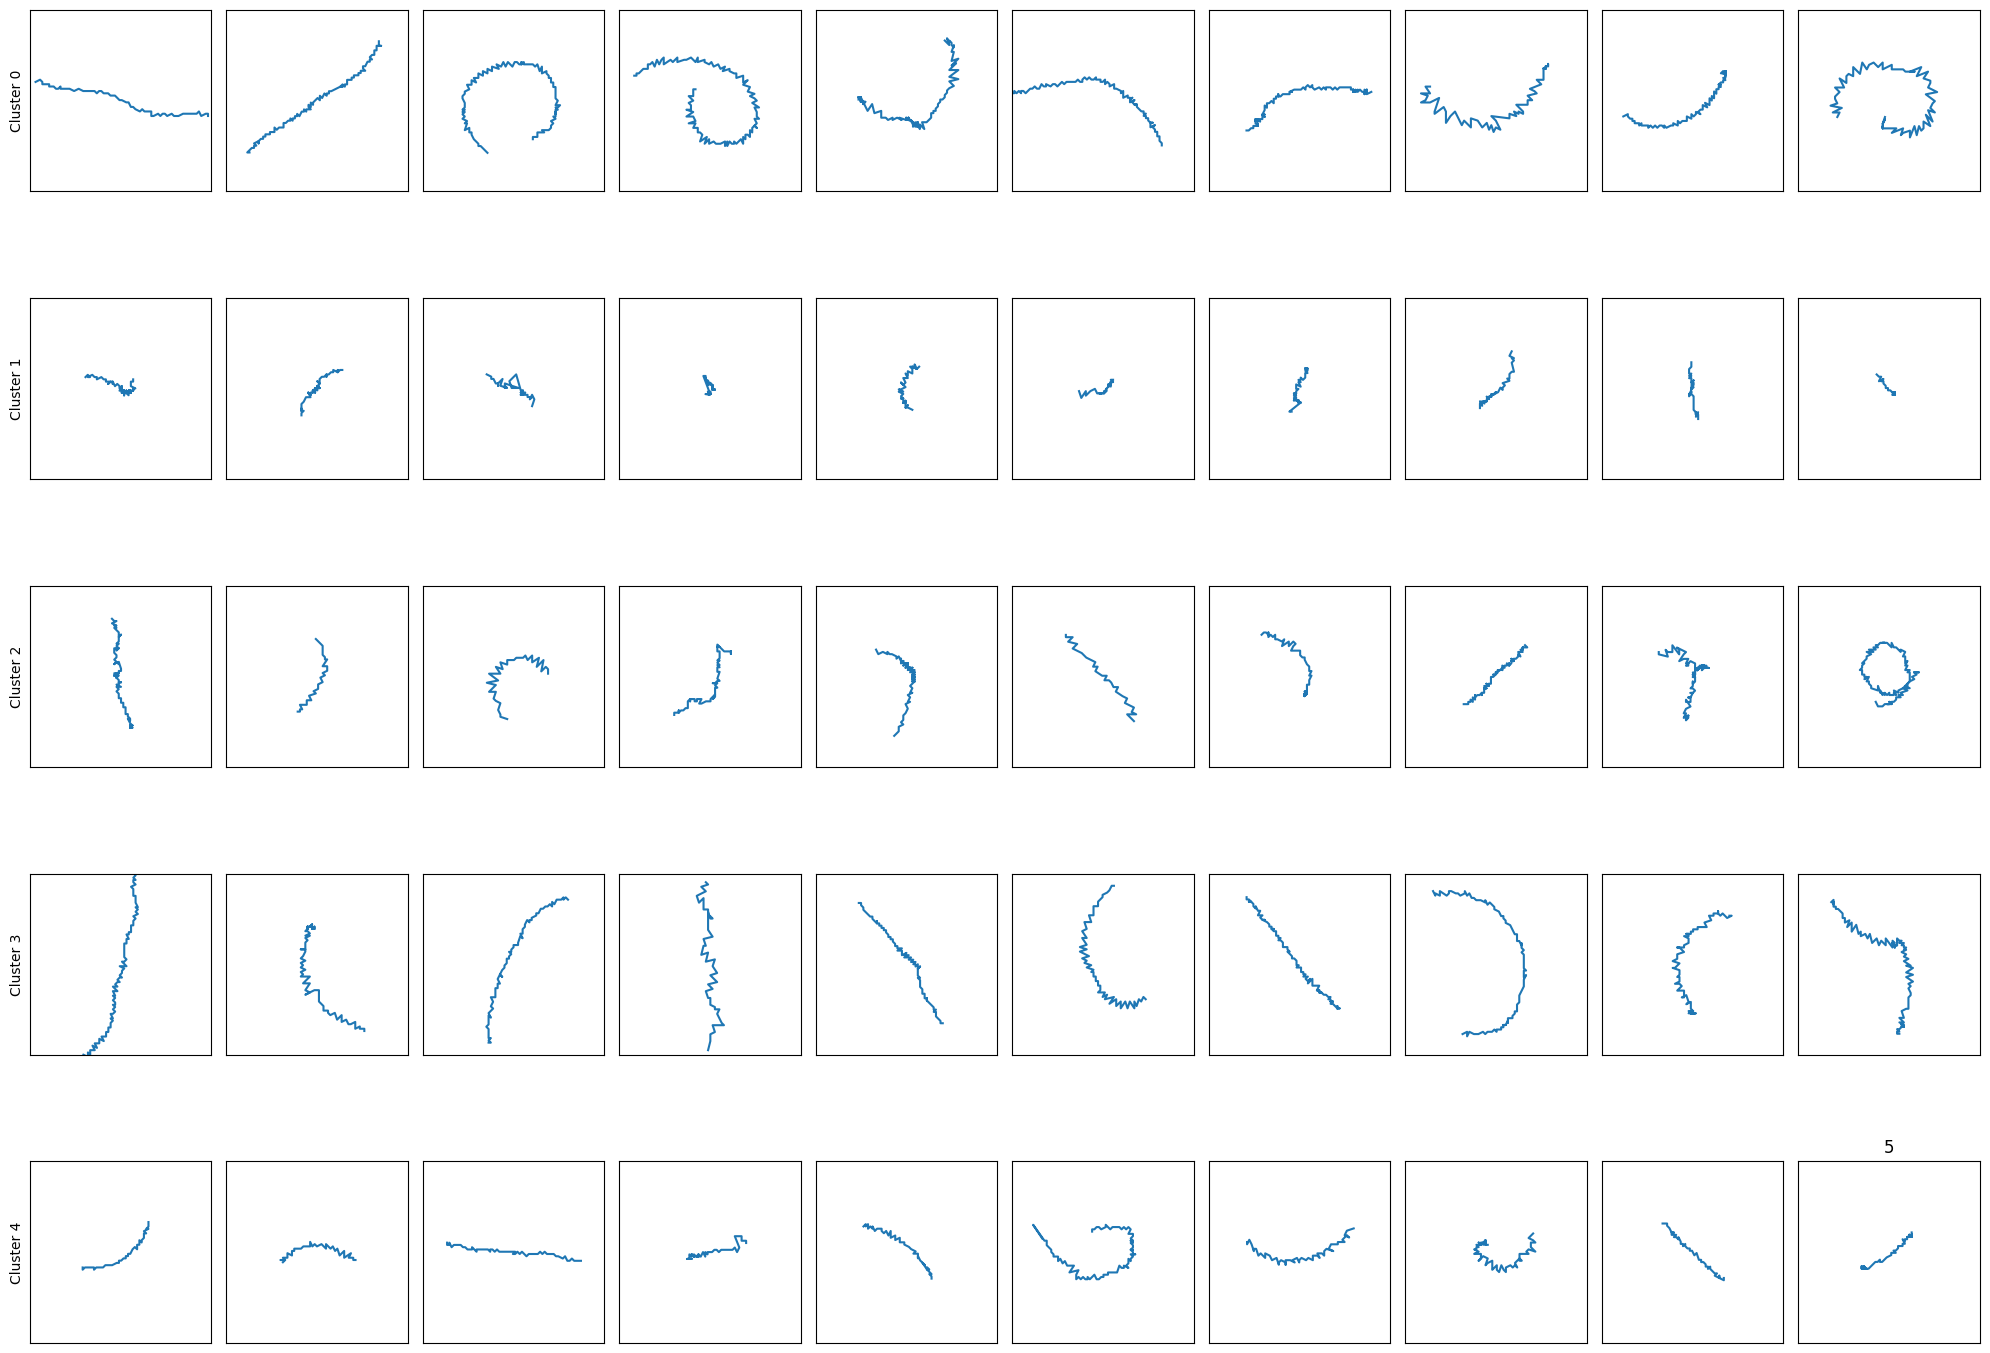

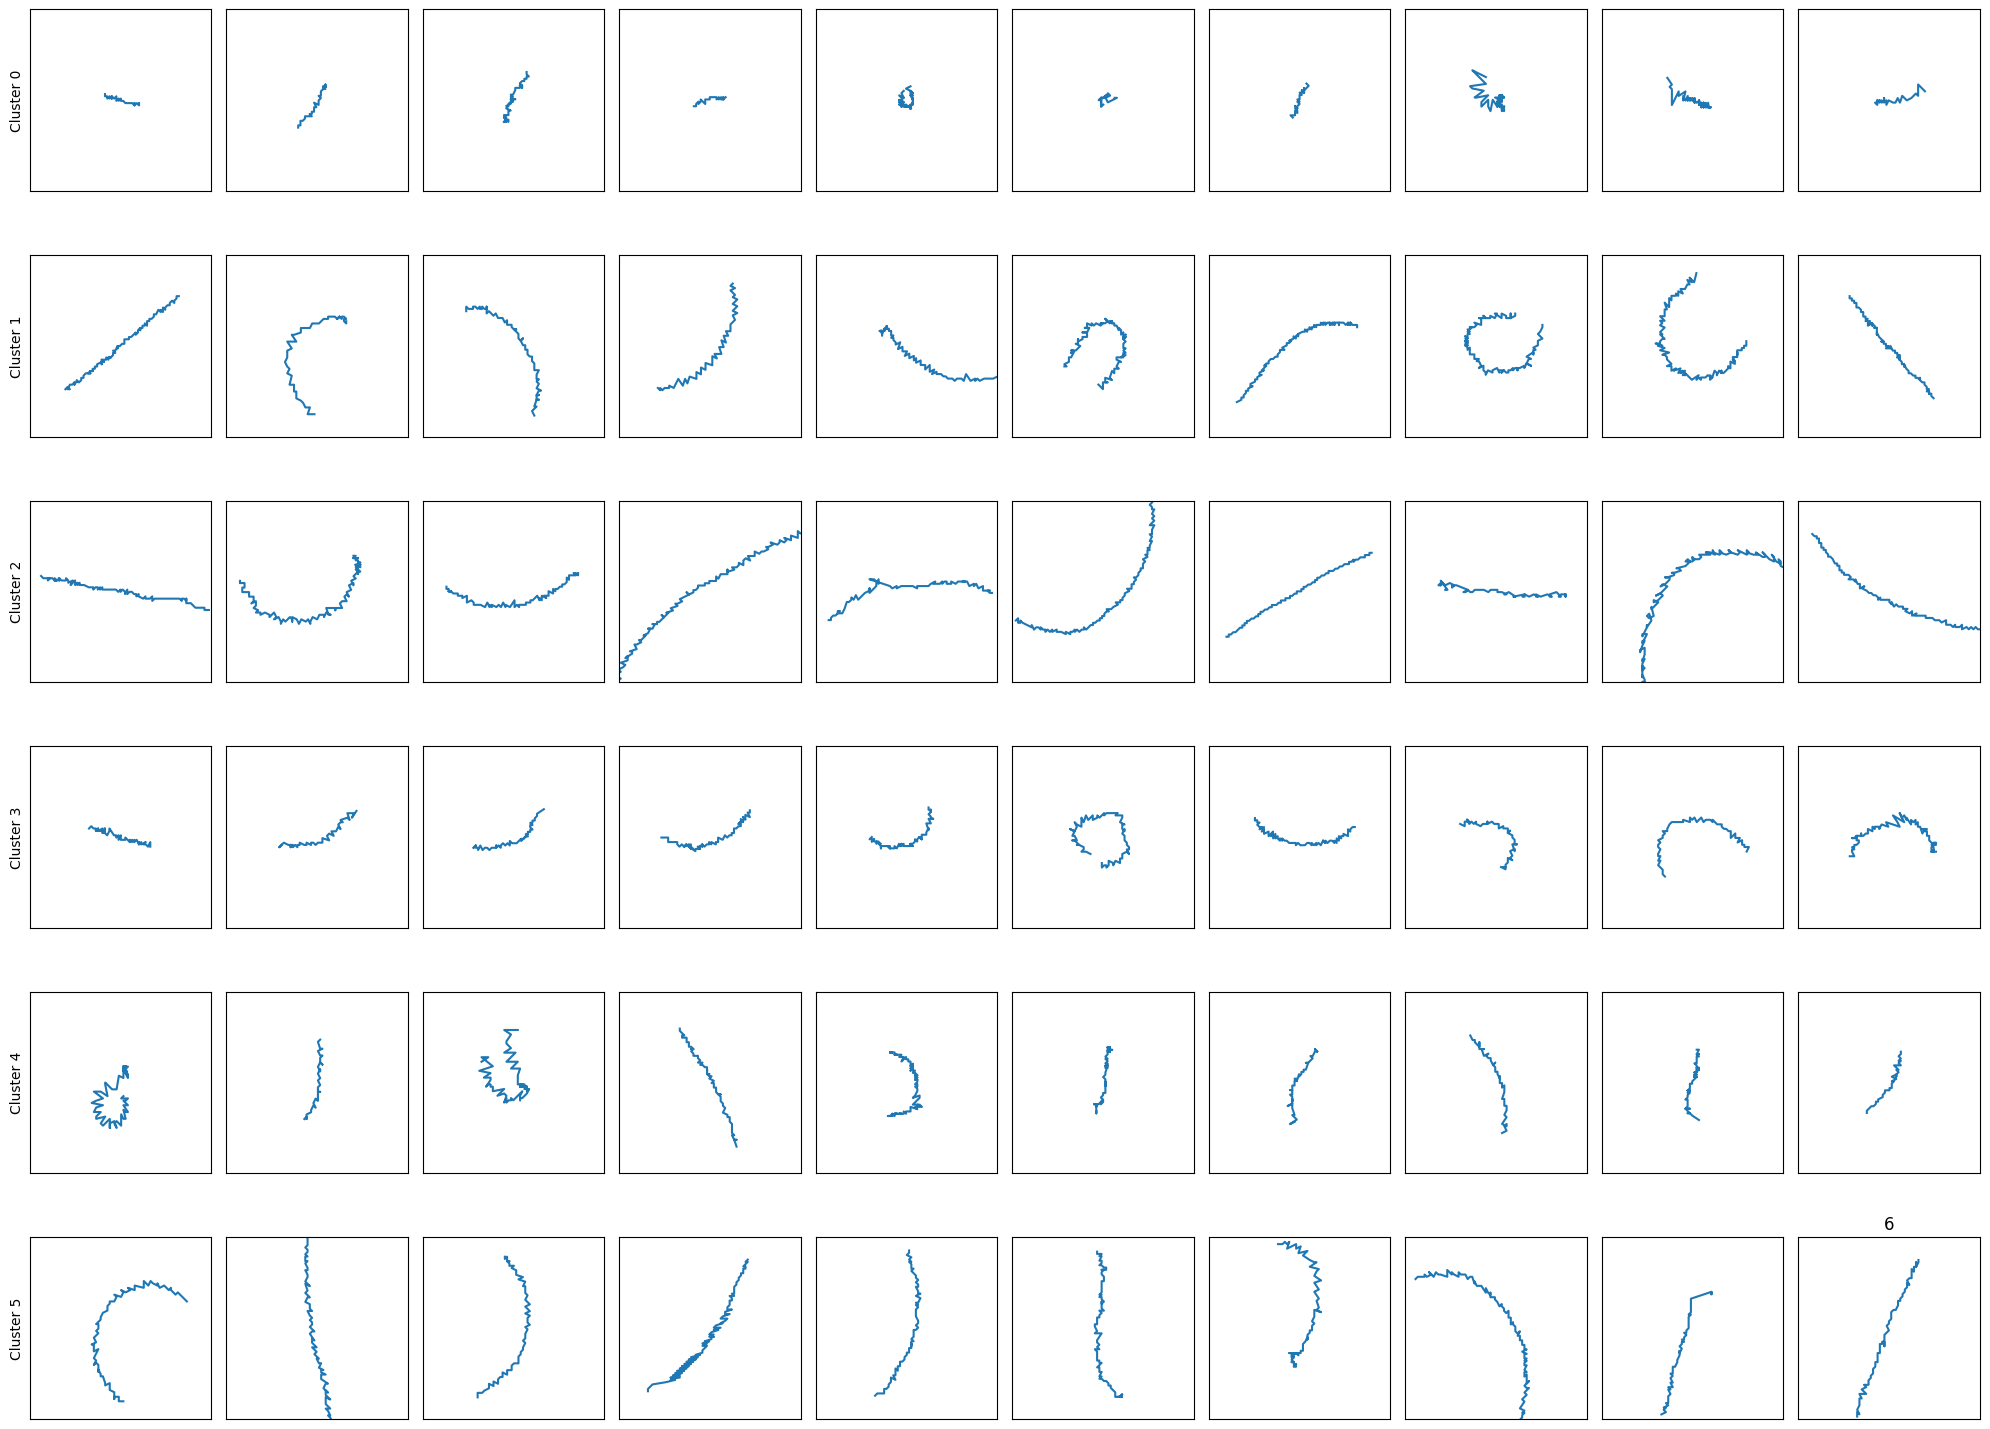

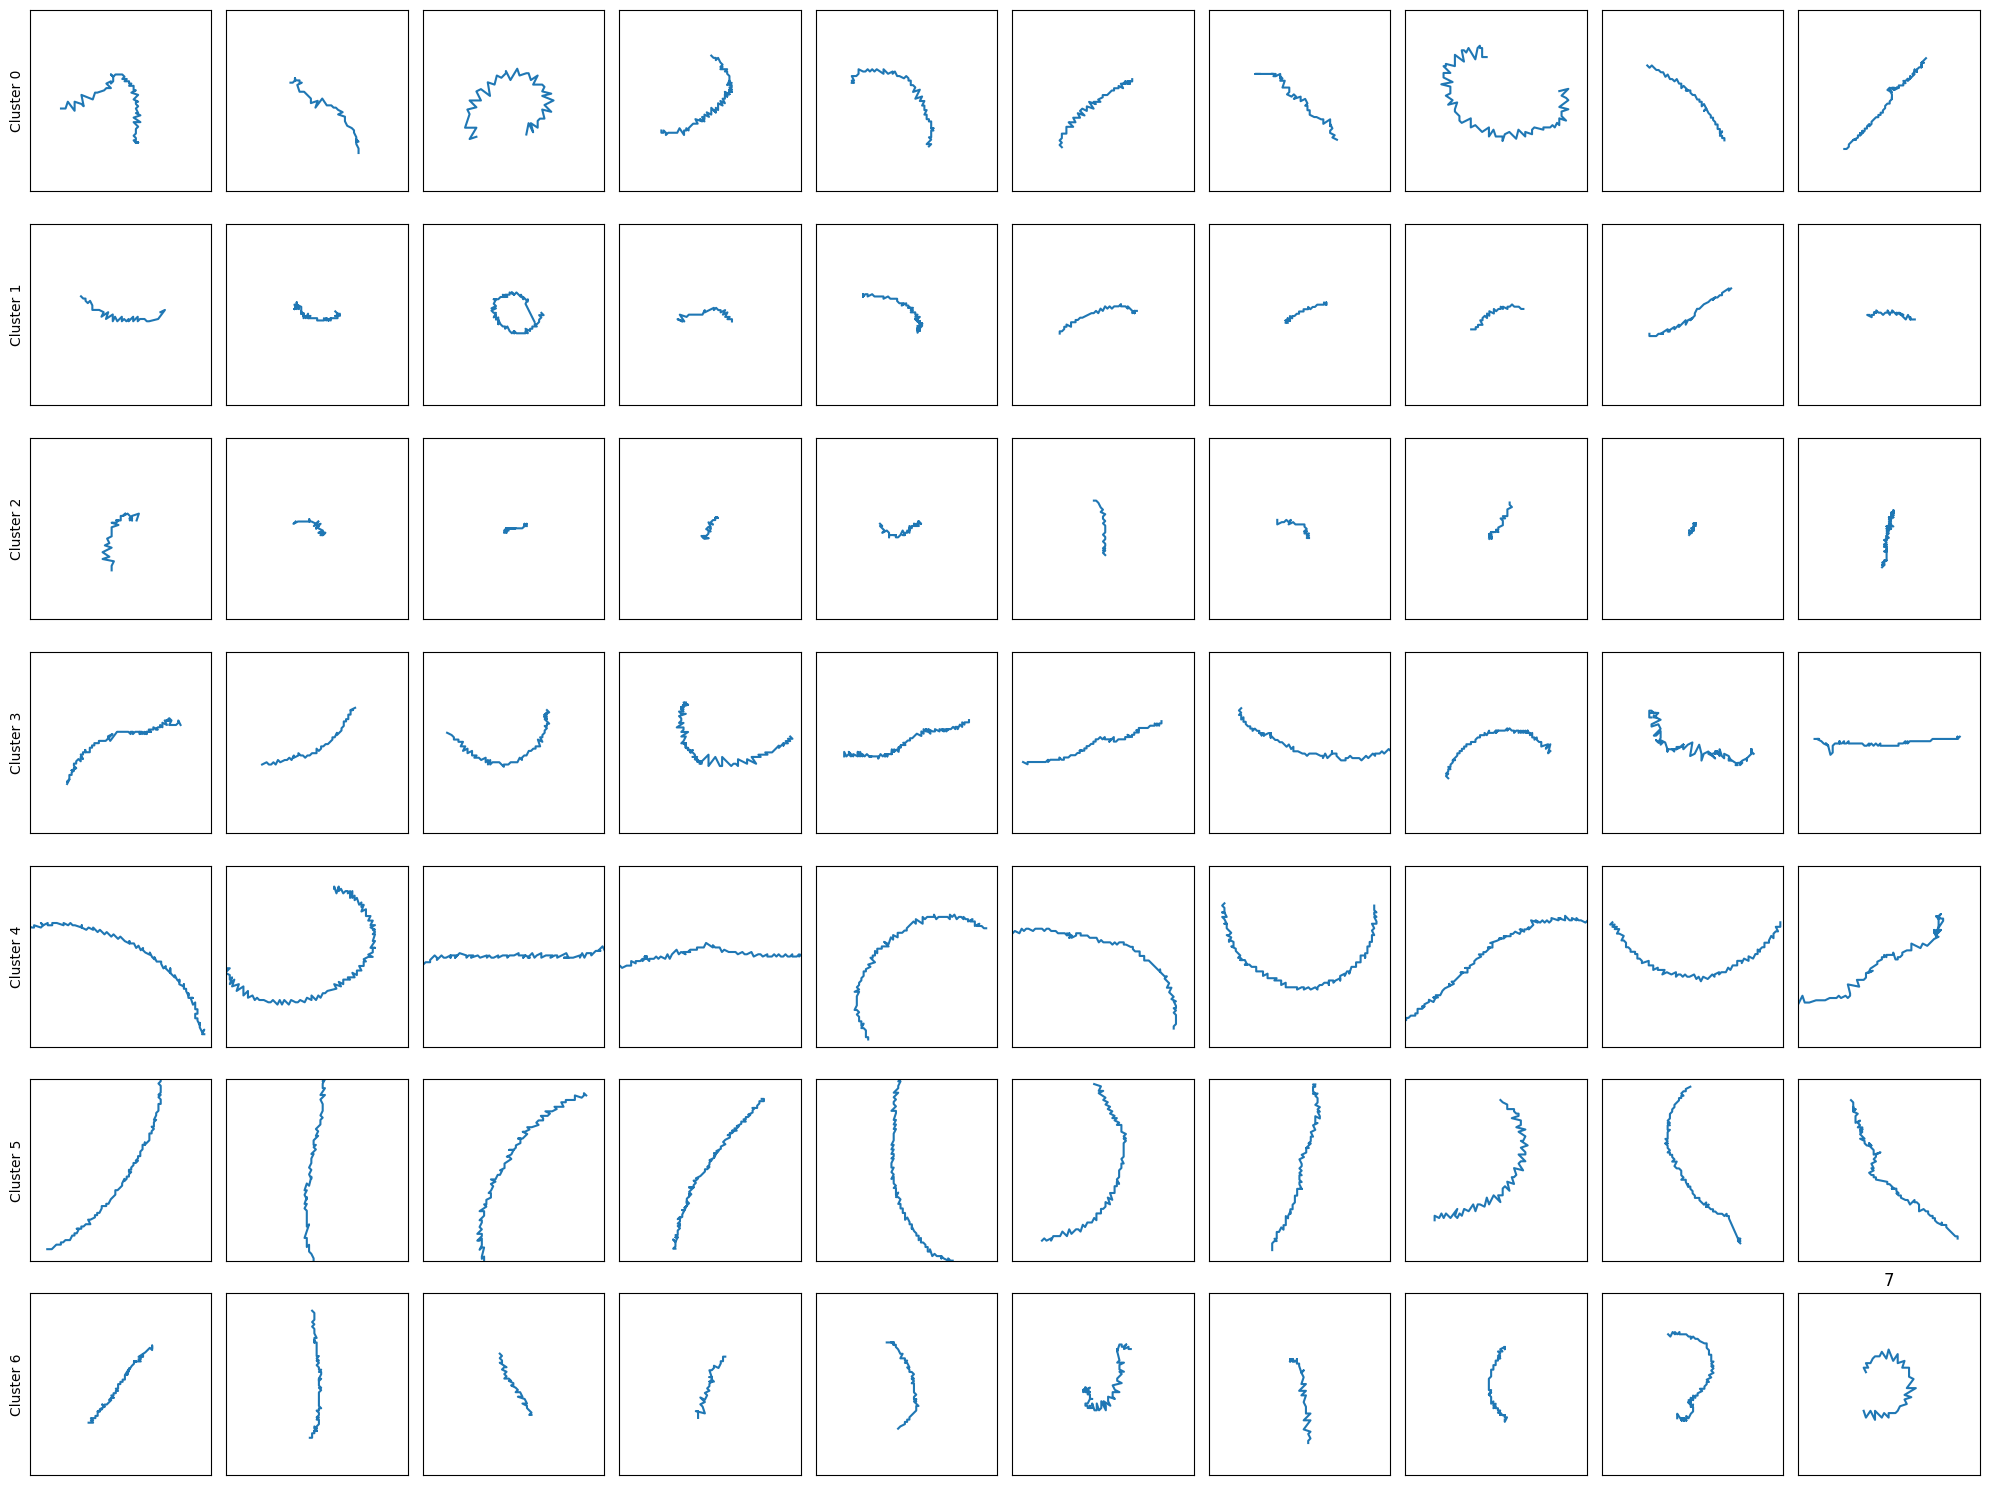

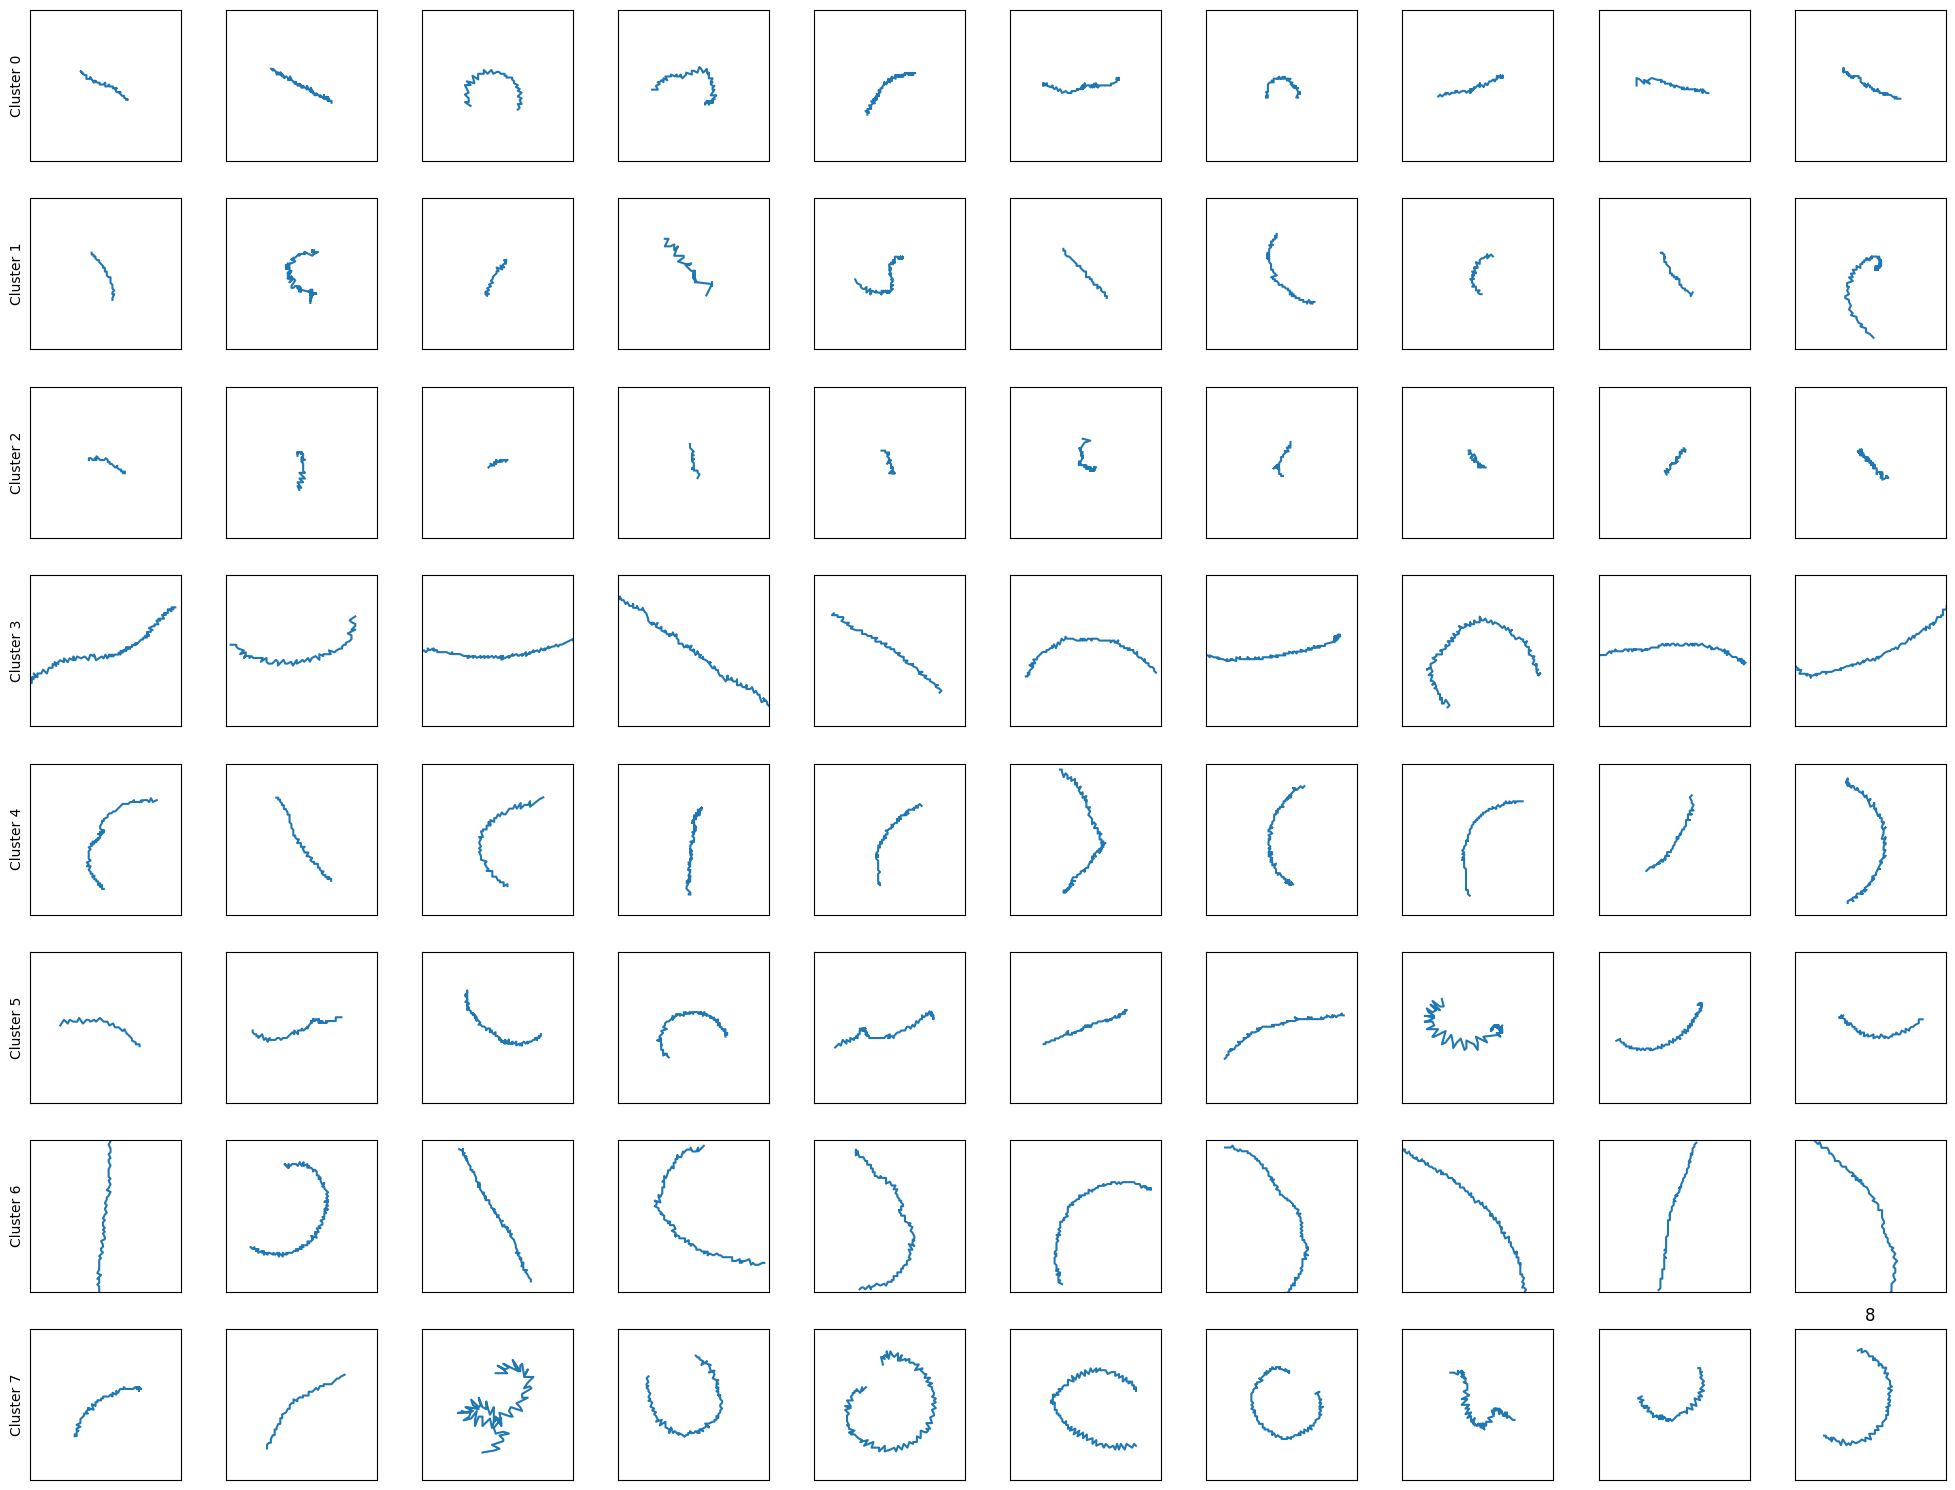

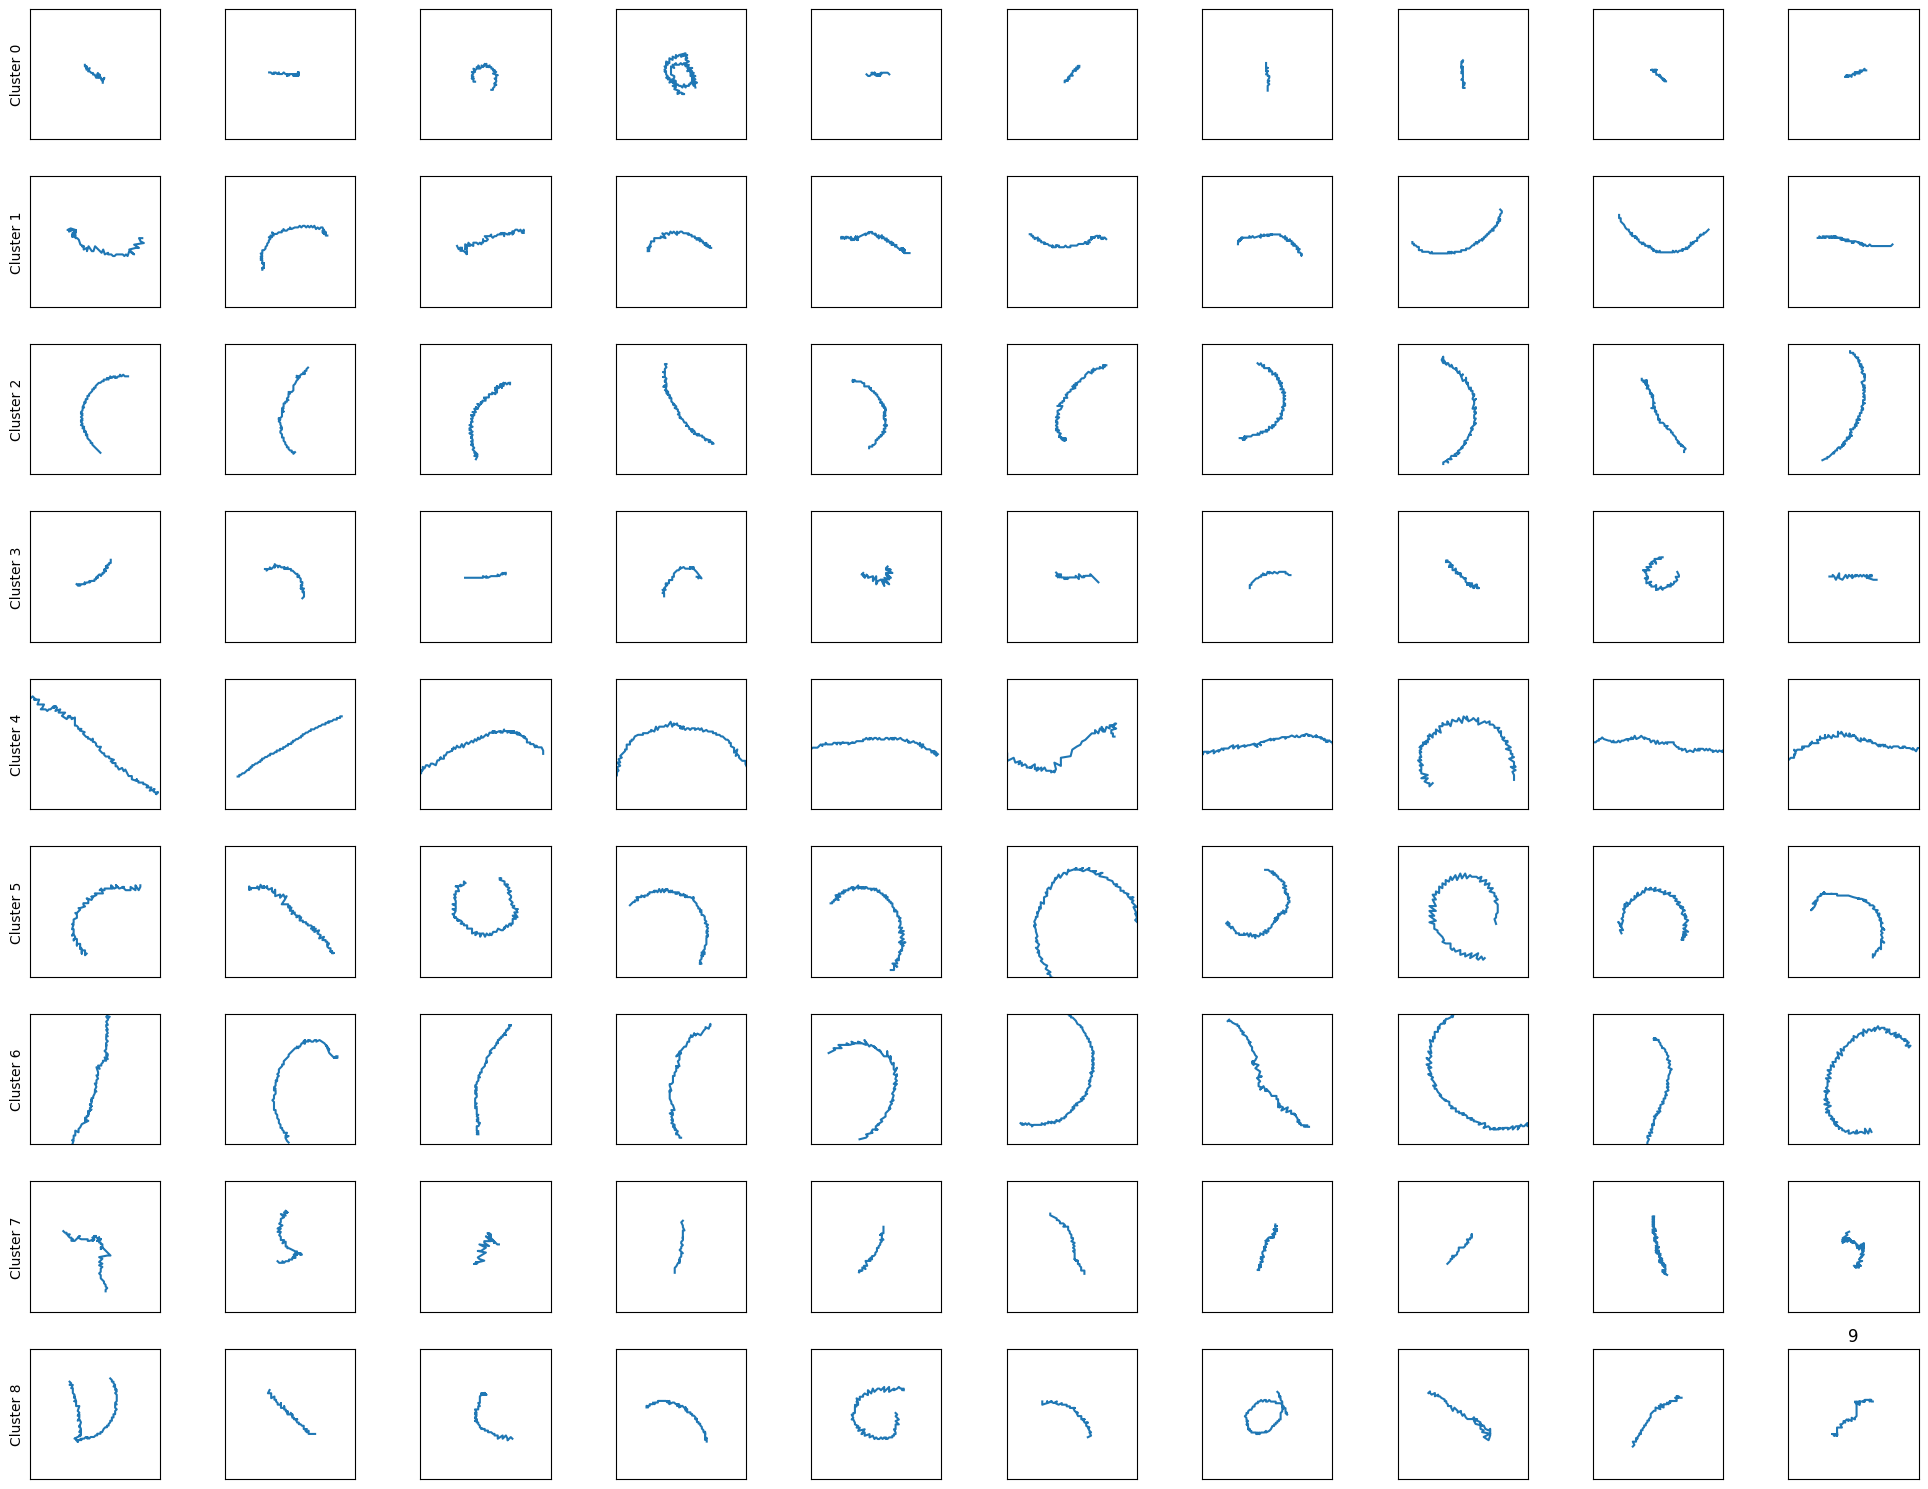

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

for c in n_clusters:
    # Number of clusters and samples per cluster
    n_samples = 10

    # Create a figure with subplots
    fig, axes = plt.subplots(c, n_samples, figsize=(20, 15))  # Adjust the size as needed

    for i in range(c):
        # Select random samples from each cluster
        cluster_data = df[df['KMean_cluster_'+str(c)] == i].sample(n=n_samples, random_state=42)
        
        for j, (index, row) in enumerate(cluster_data.iterrows()):
            ax = axes[i][j]
            # Extract the centered trajectory
            traj_array = np.array(row['centered_traj'])
            # Plot the trajectory
            ax.plot(traj_array[:, 0], traj_array[:, 1])

            ax.set_xlim(-40, 40)
            ax.set_ylim(-40, 40)
            ax.set_aspect('equal', adjustable='box')

            # Optional: Hide x and y axis labels for clarity
            ax.set_xticks([])
            ax.set_yticks([])

        # Set y-axis label for each row
        axes[i][0].set_ylabel(f"Cluster {i}")

    # Optional: adjust layout for better spacing
    plt.title(str(c))
    plt.tight_layout()
    plt.show()



In [13]:
from scipy.stats import chi2_contingency

for n in n_clusters:
    # Create a contingency table
    contingency_table = pd.crosstab(df['KMean_cluster_'+str(n)], df['exposure'])

    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(str(n))
    print("Chi-squared Test Statistic:", chi2)
    print("P-value:", p)

2
Chi-squared Test Statistic: 144.71960413995944
P-value: 2.4732205478380094e-33
3
Chi-squared Test Statistic: 177.7200938382801
P-value: 2.561957737989064e-39
4
Chi-squared Test Statistic: 160.5373515335659
P-value: 1.403348626353768e-34
5
Chi-squared Test Statistic: 162.8075755595355
P-value: 3.6536869684107245e-34
6
Chi-squared Test Statistic: 174.01410786506176
P-value: 1.0150269276778503e-35
7
Chi-squared Test Statistic: 192.97685588479337
P-value: 5.922840118393362e-39
8
Chi-squared Test Statistic: 210.01529359546606
P-value: 8.661595483751225e-42
9
Chi-squared Test Statistic: 209.7814330658745
P-value: 5.534519591253353e-41


In [14]:
exposures = df['exposure'].unique()  # [0.0, 30.0]
quantities = df['quantity'].unique()  # ['0', '1u', '100n', '10n']

In [16]:
from IPython.display import display, Markdown

# Let's assume 'n_clusters', 'exposures', and 'quantities' are predefined lists or arrays
# and 'df' is your DataFrame containing the data

for n in n_clusters:
    display(Markdown(f"### Results for {n} Clusters"))
    results = []

    for exposure in exposures:
        for quantity in quantities:
            # Filter data for each pair
            subset = df[(df['exposure'] == exposure) & (df['quantity'] == quantity)]
            
            # Create contingency table
            contingency_table = pd.crosstab(subset[f'KMean_cluster_{n}'], subset['name'])  # Assuming 'name' is the identifier

            # Perform Chi-squared test
            chi2, p, dof, expected = chi2_contingency(contingency_table)

            # Append results
            results.append({
                'Exposure': exposure,
                'Quantity': quantity,
                'Chi-squared Test Statistic': chi2,
                'P-value': f"{p:.3e}"  # Format the p-value in scientific notation
            })
    
    # Convert results to DataFrame for nicer display
    results_df = pd.DataFrame(results)
    
    # Display results DataFrame
    display(results_df)


### Results for 2 Clusters

,Exposure,Quantity,Chi-squared Test Statistic,P-value
0,0.0,0,383.347938,1.101e-81
1,0.0,1u,118.011018,1.420e-24
2,0.0,100n,35.744117,3.267e-07
3,0.0,10n,73.526193,4.084e-15
4,30.0,0,111.251009,3.937e-23
5,30.0,1u,105.929608,5.368e-22
6,30.0,100n,66.095578,1.512e-13
7,30.0,10n,119.155246,8.092e-25


### Results for 3 Clusters

,Exposure,Quantity,Chi-squared Test Statistic,P-value
0,0.0,0,446.649694,1.931e-91
1,0.0,1u,138.842438,4.130e-26
2,0.0,100n,46.029696,2.346e-07
3,0.0,10n,99.575321,5.213e-18
4,30.0,0,109.224317,5.496e-20
5,30.0,1u,112.901270,9.637e-21
6,30.0,100n,68.271650,1.084e-11
7,30.0,10n,116.822615,1.500e-21


### Results for 4 Clusters

,Exposure,Quantity,Chi-squared Test Statistic,P-value
0,0.0,0,534.774249,8.708e-107
1,0.0,1u,189.931872,3.879e-34
2,0.0,100n,57.543904,6.303e-08
3,0.0,10n,119.825169,6.697e-20
4,30.0,0,129.306472,8.503e-22
5,30.0,1u,142.766743,1.654e-24
6,30.0,100n,102.032888,2.223e-16
7,30.0,10n,160.831538,3.556e-28


### Results for 5 Clusters

,Exposure,Quantity,Chi-squared Test Statistic,P-value
0,0.0,0,579.836306,4.307e-113
1,0.0,1u,190.077570,7.960e-32
2,0.0,100n,70.647398,7.684e-09
3,0.0,10n,133.214146,1.522e-20
4,30.0,0,184.852889,8.946e-31
5,30.0,1u,166.298181,4.603e-27
6,30.0,100n,100.674621,2.589e-14
7,30.0,10n,205.374498,6.487e-35


### Results for 6 Clusters

,Exposure,Quantity,Chi-squared Test Statistic,P-value
0,0.0,0,576.164754,2.999e-109
1,0.0,1u,213.570829,2.282e-34
2,0.0,100n,123.655171,5.977e-17
3,0.0,10n,184.463303,1.296e-28
4,30.0,0,185.652683,7.569e-29
5,30.0,1u,165.735366,5.834e-25
6,30.0,100n,111.674463,9.714e-15
7,30.0,10n,213.893467,1.969e-34


### Results for 7 Clusters

,Exposure,Quantity,Chi-squared Test Statistic,P-value
0,0.0,0,621.949479,6.023e-116
1,0.0,1u,265.963727,1.108e-42
2,0.0,100n,153.650720,6.928e-21
3,0.0,10n,220.913620,8.877e-34
4,30.0,0,212.683454,3.596e-32
5,30.0,1u,177.224829,2.479e-25
6,30.0,100n,115.917084,5.145e-14
7,30.0,10n,235.348033,1.298e-36


### Results for 8 Clusters

,Exposure,Quantity,Chi-squared Test Statistic,P-value
0,0.0,0,643.267793,1.366e-117
1,0.0,1u,304.797905,2.735e-48
2,0.0,100n,178.964754,6.079e-24
3,0.0,10n,228.822841,2.135e-33
4,30.0,0,213.130804,2.187e-30
5,30.0,1u,201.095126,4.253e-28
6,30.0,100n,120.725847,1.751e-13
7,30.0,10n,212.087417,3.459e-30


### Results for 9 Clusters

,Exposure,Quantity,Chi-squared Test Statistic,P-value
0,0.0,0,715.700312,6.240e-130
1,0.0,1u,363.332977,8.186e-58
2,0.0,100n,205.169875,3.677e-27
3,0.0,10n,250.526180,1.011e-35
4,30.0,0,214.302384,7.295e-29
5,30.0,1u,217.564324,1.787e-29
6,30.0,100n,124.377654,7.907e-13
7,30.0,10n,241.666568,4.967e-34
